**기본 설정 & 임포트**

In [1]:
# === 기본 설정 & 임포트 ===
import os, glob, json, math, random, gc
import numpy as np
from collections import defaultdict
from statistics import mean

# 재현성
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# ★ 사용자 설정
PROJECT_TAG   = "v2"                  # 추출할 때 사용한 project_tag
BASE_DIR      = os.getcwd()           # 노트북 위치 기준
DATA_ROOT     = os.path.join(BASE_DIR, PROJECT_TAG, f"data_{PROJECT_TAG}")

# 라벨(폴더명과 동일)
KOREAN_LABELS = [
    '왼쪽-협측','중앙-협측','오른쪽-협측',
    '왼쪽-구개측','중앙-구개측','오른쪽-구개측',
    '왼쪽-설측','중앙-설측','오른쪽-설측',
    '오른쪽-위-씹는면','왼쪽-위-씹는면','왼쪽-아래-씹는면','오른쪽-아래-씹는면'
]
label_to_idx = {lab:i for i,lab in enumerate(KOREAN_LABELS)}

# ★ 윈도우/필터 기본값 (15fps 기준)
SEQ_LEN            = 45   # 3초 창
STRIDE             = 15   # 1초 간격
MIN_ACTIVE_RATIO   = 0.20 # 창 내 손-검출 프레임 비율 하한
ACTIVE_EPS         = 1e-7 # 손 좌표 all-zero 판정 임계


**매니페스트 스캔(폴더 탐색, 각 .npy의 T,F 추출)**

In [2]:
# === 매니페스트 스캔 ===
manifest = []
for lab in KOREAN_LABELS:
    lab_dir = os.path.join(DATA_ROOT, lab)
    if not os.path.isdir(lab_dir):
        continue
    for person in sorted(os.listdir(lab_dir)):
        pdir = os.path.join(lab_dir, person)
        if not os.path.isdir(pdir):
            continue
        for npy in glob.glob(os.path.join(pdir, "*.npy")):
            arr = np.load(npy)
            T, F = (arr.shape[0], arr.shape[1]) if arr.ndim==2 else (0,0)
            manifest.append({
                "label": lab,
                "y": label_to_idx[lab],
                "person": person,
                "path": npy,
                "T": T,
                "F": F
            })

len(manifest), manifest[:2]


(656,
 [{'label': '왼쪽-협측',
   'y': 0,
   'person': 'P01',
   'path': 'd:\\Final_Team3\\v2\\data_v2\\왼쪽-협측\\P01\\1755673634.npy',
   'T': 150,
   'F': 48},
  {'label': '왼쪽-협측',
   'y': 0,
   'person': 'P01',
   'path': 'd:\\Final_Team3\\v2\\data_v2\\왼쪽-협측\\P01\\1755674027.npy',
   'T': 150,
   'F': 48}])

**전역 통계 출력(특징 차원 단일성 검사, 길이 통계)**

In [3]:
# === 데이터 전역 통계 ===
feat_dims = sorted(set(m["F"] for m in manifest))
lens      = [m["T"] for m in manifest]
print("Feature dims found:", feat_dims)
print(f"Clips: {len(lens)}, mean T: {mean(lens):.1f}, min T: {min(lens)}, max T: {max(lens)}")

assert len(feat_dims)==1, "여러 차원의 npy가 섞여있어요. 추출 스크립트 버전을 통일하세요."
FEAT_DIM = feat_dims[0]
print("FEAT_DIM =", FEAT_DIM)


Feature dims found: [48]
Clips: 656, mean T: 150.0, min T: 138, max T: 150
FEAT_DIM = 48


**윈도잉/마스크 유틸(sliding_windows, frame_active_mask, active_ratio_of_window)**

In [4]:
# === 윈도잉 & 마스크 유틸 ===
def frame_active_mask(win, hand_dims=42, eps=ACTIVE_EPS):
    """
    win: (L, F)  # 스케일링 '전' 윈도
    반환: (L, 1)  # 0/1 마스크
    """
    e = np.abs(win[:, :hand_dims]).sum(axis=1)
    return (e > eps).astype(np.float32)[:, None]

def sliding_windows(arr, seq_len=SEQ_LEN, stride=STRIDE, pad_mode="left"):
    """
    arr: (T, F) -> [(seq_len, F), ...]
    """
    T, F = arr.shape
    if T == 0:
        return []
    if T < seq_len:
        pad = np.zeros((seq_len - T, F), dtype=arr.dtype)
        if pad_mode == "left":
            return [np.vstack([pad, arr])]
        else:
            return [np.vstack([arr, pad])]
    out = []
    for s in range(0, T - seq_len + 1, stride):
        out.append(arr[s:s+seq_len])
    if (T - seq_len) % stride != 0:
        out.append(arr[-seq_len:])
    return out

def active_ratio_of_window(win, hand_dims=42, eps=ACTIVE_EPS):
    """
    손 좌표(앞 hand_dims)를 프레임별로 검사하여 non-zero 프레임 비율 반환
    """
    H = min(hand_dims, win.shape[1])
    fr = win[:, :H]
    nz = (np.abs(fr).sum(axis=1) > eps)
    return nz.mean()


**윈도 생성 및 필터링(활성 비율 기준으로 keep/drop → X, M, y, meta)**

In [5]:
# === 윈도 생성 및 필터링 ===
X, M, y, meta = [], [], [], []

kept = 0
dropped_short = 0
dropped_inactive = 0

for m in manifest:
    arr = np.load(m["path"])
    wins = sliding_windows(arr, SEQ_LEN, STRIDE, pad_mode="left")
    if not wins:
        dropped_short += 1
        continue
    for w in wins:
        if active_ratio_of_window(w, hand_dims=42) >= MIN_ACTIVE_RATIO:
            X.append(w)                             # (L, F)
            M.append(frame_active_mask(w))          # (L, 1)
            y.append(m["y"])                        # 13-class
            meta.append({"label": m["label"], "person": m["person"], "src": m["path"]})
            kept += 1
        else:
            dropped_inactive += 1

X = np.stack(X, axis=0)   # (N, L, F)
M = np.stack(M, axis=0)   # (N, L, 1)
y = np.array(y)           # (N,)
print(f"Windows kept: {kept}, dropped_short: {dropped_short}, dropped_inactive: {dropped_inactive}")
print("X shape:", X.shape, "M shape:", M.shape, "y shape:", y.shape)


Windows kept: 5248, dropped_short: 0, dropped_inactive: 0
X shape: (5248, 45, 48) M shape: (5248, 45, 1) y shape: (5248,)


**LOSO 분할 + 스케일링(train으로만 StandardScaler.fit)**

In [6]:
# === LOSO 분할 + 스케일링 (모델 학습 없이) ===
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler

persons = np.array([m["person"] for m in meta])  # 길이 N
F = X.shape[-1]
HAND_DIMS = 42 if F >= 42 else F
EPS = 1e-7

logo = LeaveOneGroupOut()
folds = []
fold_no = 0

for train_idx, val_idx in logo.split(X, y, groups=persons):
    fold_no += 1
    X_train, y_train = X[train_idx], y[train_idx]
    X_val,   y_val   = X[val_idx],   y[val_idx]
    persons_train, persons_val = persons[train_idx], persons[val_idx]

    # 스케일러: train으로만 fit
    scaler = StandardScaler(with_mean=True, with_std=True)

    Xtr_flat = X_train.reshape(-1, F)
    mask = (np.abs(Xtr_flat[:, :HAND_DIMS]).sum(axis=1) > EPS)
    if mask.any():
        scaler.fit(Xtr_flat[mask])
    else:
        scaler.fit(Xtr_flat)

    X_train_s = scaler.transform(X_train.reshape(-1, F)).reshape(X_train.shape)
    X_val_s   = scaler.transform(X_val.reshape(-1, F)).reshape(X_val.shape)

    folds.append({
        "train_idx": train_idx, "val_idx": val_idx,
        "X_train_s": X_train_s, "y_train": y_train, "persons_train": persons_train,
        "X_val_s":   X_val_s,   "y_val":   y_val,   "persons_val":   persons_val,
        "scaler": scaler
    })

    print(f"[LOSO Fold {fold_no}] Train {X_train_s.shape}, Val {X_val_s.shape} | "
          f"persons train={len(set(persons_train))}, val={len(set(persons_val))}")


[LOSO Fold 1] Train (4728, 45, 48), Val (520, 45, 48) | persons train=21, val=1
[LOSO Fold 2] Train (4728, 45, 48), Val (520, 45, 48) | persons train=21, val=1
[LOSO Fold 3] Train (4936, 45, 48), Val (312, 45, 48) | persons train=21, val=1
[LOSO Fold 4] Train (5040, 45, 48), Val (208, 45, 48) | persons train=21, val=1
[LOSO Fold 5] Train (5040, 45, 48), Val (208, 45, 48) | persons train=21, val=1
[LOSO Fold 6] Train (5040, 45, 48), Val (208, 45, 48) | persons train=21, val=1
[LOSO Fold 7] Train (5040, 45, 48), Val (208, 45, 48) | persons train=21, val=1
[LOSO Fold 8] Train (5040, 45, 48), Val (208, 45, 48) | persons train=21, val=1
[LOSO Fold 9] Train (5040, 45, 48), Val (208, 45, 48) | persons train=21, val=1
[LOSO Fold 10] Train (5040, 45, 48), Val (208, 45, 48) | persons train=21, val=1
[LOSO Fold 11] Train (5040, 45, 48), Val (208, 45, 48) | persons train=21, val=1
[LOSO Fold 12] Train (5048, 45, 48), Val (200, 45, 48) | persons train=21, val=1
[LOSO Fold 13] Train (5072, 45, 48), 

**GPU 메모리 설정**

In [7]:
# === GPU 메모리 점진 할당 (중복 제거) ===
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for g in gpus:
            tf.config.experimental.set_memory_growth(g, True)
        print("GPU memory growth enabled.")
    except Exception as e:
        print("set_memory_growth 실패:", e)


GPU memory growth enabled.


**멀티태스크용 라벨 매핑(좌/중/우 & 상/하)**

In [8]:
# === 멀티태스크 라벨 매핑 ===
labels_np = np.array(KOREAN_LABELS, dtype=object)
y13 = y  # 가독성을 위해 별칭

def map_pos(label_str):
    # 0:왼, 1:중, 2:오
    if '왼쪽' in label_str:   return 0
    if '중앙' in label_str:   return 1
    if '오른쪽' in label_str: return 2
    raise ValueError(f"pos mapping 실패: {label_str}")

def map_ud(label_str):
    # 0:위, 1:아래
    if ('구개측' in label_str) or ('위-씹는면' in label_str):   return 0
    if ('설측' in label_str)  or ('아래-씹는면' in label_str):  return 1
    # 협측은 첫판에서 제외 (UD 모호)
    return None

# 두 태스크 모두 유효한 샘플로 필터
keep_idx = []
y_pos_all, y_ud_all = [], []
for i, yi in enumerate(y13):
    s = labels_np[yi]
    p = map_pos(s)
    u = map_ud(s)
    if u is None:
        continue
    keep_idx.append(i)
    y_pos_all.append(p)
    y_ud_all.append(u)

keep_idx = np.array(keep_idx, dtype=int)
X_mt     = X[keep_idx]
M_mt     = M[keep_idx]
y_pos    = np.array(y_pos_all, dtype=int)
y_ud     = np.array(y_ud_all,  dtype=int)
meta_mt  = [meta[i] for i in keep_idx]
persons_mt = np.array([m["person"] for m in meta_mt])

print("멀티태스크 샘플:", X_mt.shape, "pos shape:", y_pos.shape, "ud shape:", y_ud.shape)


멀티태스크 샘플: (4016, 45, 48) pos shape: (4016,) ud shape: (4016,)


**멀티태스크 모델(공유 인코더 + 2헤드)**

In [16]:
from tensorflow.keras import layers, regularizers, Model
import tensorflow as tf

def build_multitask_from_gru(input_shape,
                             l2=1e-4,
                             p_in_noise=0.01,
                             p_spatialdrop=0.2,
                             gru1_units=96, gru2_units=64,
                             p_head_drop=0.5,
                             lr=3e-4,
                             loss_w_pos=1.0, loss_w_ud=0.5):  # ← 초기는 pos에 더 가중
    inp = layers.Input(shape=input_shape, name="inp_x")  # (L, F)

    # === 공유 인코더: 단일태스크에서 성능 좋았던 블록 그대로 ===
    x = layers.GaussianNoise(p_in_noise)(inp)
    x = layers.SpatialDropout1D(p_spatialdrop)(x)
    x = layers.GRU(
        gru1_units, return_sequences=True,
        dropout=0.3, recurrent_dropout=0.0,
        kernel_regularizer=regularizers.l2(l2),
        recurrent_regularizer=regularizers.l2(l2)
    )(x)
    x = layers.GRU(
        gru2_units, return_sequences=False,
        dropout=0.3, recurrent_dropout=0.0,
        kernel_regularizer=regularizers.l2(l2),
        recurrent_regularizer=regularizers.l2(l2)
    )(x)
    shared = layers.BatchNormalization(name="shared_bn")(x)

    # 공통 FC 한 층도 단일 모델과 동일하게
    base = layers.Dense(64, activation="relu",
                        kernel_regularizer=regularizers.l2(l2))(shared)
    base = layers.Dropout(p_head_drop)(base)

    # === Head #1: 좌/중/우 (3-class)
    h1 = layers.Dense(64, activation='relu',
                      kernel_regularizer=regularizers.l2(l2))(base)
    h1 = layers.Dropout(p_head_drop)(h1)
    out_pos = layers.Dense(3, activation='softmax', name="out_pos")(h1)

    # === Head #2: 상/하 (2-class)
    h2 = layers.Dense(64, activation='relu',
                      kernel_regularizer=regularizers.l2(l2))(base)
    h2 = layers.Dropout(p_head_drop)(h2)
    out_ud = layers.Dense(2, activation='softmax', name="out_ud")(h2)

    model = Model(inputs=inp, outputs=[out_pos, out_ud])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr, clipnorm=1.0),
        loss={
            "out_pos": tf.keras.losses.SparseCategoricalCrossentropy(),
            "out_ud":  tf.keras.losses.SparseCategoricalCrossentropy(),
        },
        loss_weights={"out_pos": loss_w_pos, "out_ud": loss_w_ud},
        metrics={"out_pos": ["accuracy"], "out_ud": ["accuracy"]}
    )
    return model


**멀티태스크용 LOSO 스케일링(부분집합에 맞춰 재적용)**

In [41]:
# === 멀티태스크용 LOSO 스케일링 ===
# persons_mt, keep_idx를 사용하여 기존 folds 인덱스에서 교집합 슬라이싱

folds_mt = []
fold_no = 0
for f in folds:
    fold_no += 1
    tr_idx_global = f["train_idx"]
    va_idx_global = f["val_idx"]

    # 멀티태스크 keep 인덱스에서, 해당 fold의 train/val에 해당하는 마스크를 만듦
    keep_set = set(keep_idx.tolist())
    tr_keep = [i for i in tr_idx_global if i in keep_set]
    va_keep = [i for i in va_idx_global if i in keep_set]
    if len(tr_keep)==0 or len(va_keep)==0:
        # 해당 fold에 멀티태스크 유효 샘플이 없으면 스킵
        print(f"[MT Fold {fold_no}] skip (no valid samples)")
        continue

    # 멀티태스크 배열 기준 새 인덱스(keep 기준으로 다시 매핑)
    # global i -> position in keep_idx
    pos_map = {g:i for i,g in enumerate(keep_idx.tolist())}
    tr_pos = np.array([pos_map[i] for i in tr_keep], dtype=int)
    va_pos = np.array([pos_map[i] for i in va_keep], dtype=int)

    Xtr_mt, Xva_mt = X_mt[tr_pos], X_mt[va_pos]
    y_pos_tr, y_pos_va = y_pos[tr_pos], y_pos[va_pos]
    y_ud_tr,  y_ud_va  = y_ud[tr_pos],  y_ud[va_pos]
    persons_tr_mt = persons_mt[tr_pos]
    persons_va_mt = persons_mt[va_pos]

    # 스케일러는 해당 fold의 scaler를 재사용해도 되지만,
    # 멀티태스크 부분집합 기준으로 다시 fit해도 무방(여기선 재fit X, 기존 scaler로 transform만)
    scaler = f["scaler"]
    F = Xtr_mt.shape[-1]
    Xtr_mt_s = scaler.transform(Xtr_mt.reshape(-1,F)).reshape(Xtr_mt.shape)
    Xva_mt_s = scaler.transform(Xva_mt.reshape(-1,F)).reshape(Xva_mt.shape)

    src_tr_mt = np.array([meta_mt[p]["src"] for p in tr_pos])
    src_va_mt = np.array([meta_mt[p]["src"] for p in va_pos])

    folds_mt.append({
        "Xtr": Xtr_mt_s, "Xva": Xva_mt_s,
        "y_pos_tr": y_pos_tr, "y_pos_va": y_pos_va,
        "y_ud_tr":  y_ud_tr,  "y_ud_va":  y_ud_va,
        "persons_tr": persons_tr_mt, "persons_va": persons_va_mt,
        "src_tr": src_tr_mt, "src_va": src_va_mt,       # ★ 추가
        "tr_pos": tr_pos, "va_pos": va_pos              # (옵션) 추적/복구용
    })
    print(f"[MT Fold {fold_no}] Train {Xtr_mt_s.shape}, Val {Xva_mt_s.shape}, "
          f"persons train={len(set(persons_tr_mt))}, val={len(set(persons_va_mt))}")


[MT Fold 1] Train (3616, 45, 48), Val (400, 45, 48), persons train=21, val=1
[MT Fold 2] Train (3616, 45, 48), Val (400, 45, 48), persons train=21, val=1
[MT Fold 3] Train (3776, 45, 48), Val (240, 45, 48), persons train=21, val=1
[MT Fold 4] Train (3856, 45, 48), Val (160, 45, 48), persons train=21, val=1
[MT Fold 5] Train (3856, 45, 48), Val (160, 45, 48), persons train=21, val=1
[MT Fold 6] Train (3856, 45, 48), Val (160, 45, 48), persons train=21, val=1
[MT Fold 7] Train (3856, 45, 48), Val (160, 45, 48), persons train=21, val=1
[MT Fold 8] Train (3856, 45, 48), Val (160, 45, 48), persons train=21, val=1
[MT Fold 9] Train (3856, 45, 48), Val (160, 45, 48), persons train=21, val=1
[MT Fold 10] Train (3856, 45, 48), Val (160, 45, 48), persons train=21, val=1
[MT Fold 11] Train (3856, 45, 48), Val (160, 45, 48), persons train=21, val=1
[MT Fold 12] Train (3872, 45, 48), Val (144, 45, 48), persons train=21, val=1
[MT Fold 13] Train (3888, 45, 48), Val (128, 45, 48), persons train=21, v

**학습 하이퍼파라미터 & 클래스 가중치 헬퍼**

In [45]:
# === 학습 하이퍼파라미터 & 클래스 가중치 헬퍼 ===
EPOCHS = 60
BATCH_SIZE = 64
ES_PATIENCE = 12
RLR_PATIENCE = 6

def make_class_weight(y_int):
    binc = np.bincount(y_int)
    med = float(np.median(binc[binc>0])) if np.any(binc>0) else 1.0
    return {i: (med / c) if c>0 else 1.0 for i, c in enumerate(binc)}

def make_sample_weight(y_int, cw_dict):
    # y_int: (N,) 정수 라벨
    # cw_dict: {class_idx: weight}
    return np.asarray([cw_dict[int(c)] for c in y_int], dtype=np.float32)


**멀티태스크 학습 루프(LOSO)**


===== [Multitask LOSO Fold 1] =====
Epoch 1/60
57/57 [==============================] - 3s 20ms/step - loss: 2.1133 - out_pos_loss: 1.5956 - out_ud_loss: 0.9235 - out_pos_accuracy: 0.3966 - out_ud_accuracy: 0.5277 - val_loss: 1.3925 - val_out_pos_loss: 1.0248 - val_out_ud_loss: 0.6236 - val_out_pos_accuracy: 0.6300 - val_out_ud_accuracy: 0.7000 - lr: 3.0000e-04
Epoch 2/60
57/57 [==============================] - 1s 11ms/step - loss: 1.7271 - out_pos_loss: 1.2847 - out_ud_loss: 0.7732 - out_pos_accuracy: 0.4369 - out_ud_accuracy: 0.5628 - val_loss: 1.2913 - val_out_pos_loss: 0.9405 - val_out_ud_loss: 0.5901 - val_out_pos_accuracy: 0.5625 - val_out_ud_accuracy: 0.7175 - lr: 3.0000e-04
Epoch 3/60
57/57 [==============================] - 1s 10ms/step - loss: 1.5586 - out_pos_loss: 1.1496 - out_ud_loss: 0.7068 - out_pos_accuracy: 0.4981 - out_ud_accuracy: 0.5896 - val_loss: 1.1765 - val_out_pos_loss: 0.8330 - val_out_ud_loss: 0.5759 - val_out_pos_accuracy: 0.6425 - val_out_ud_accuracy: 0.6

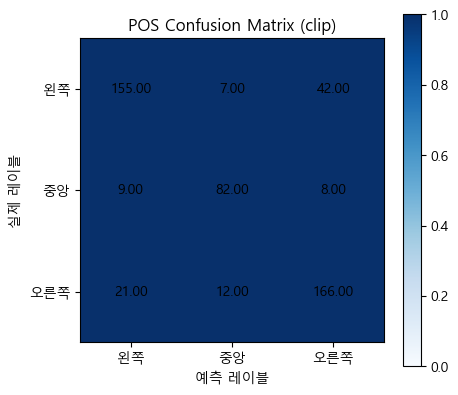

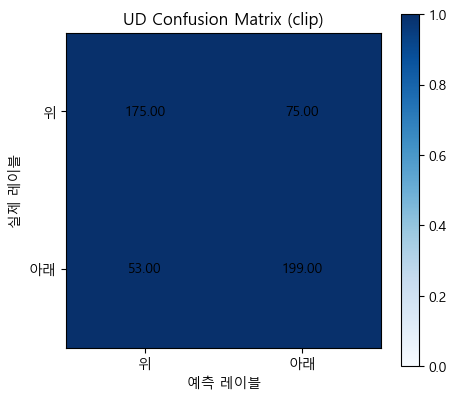

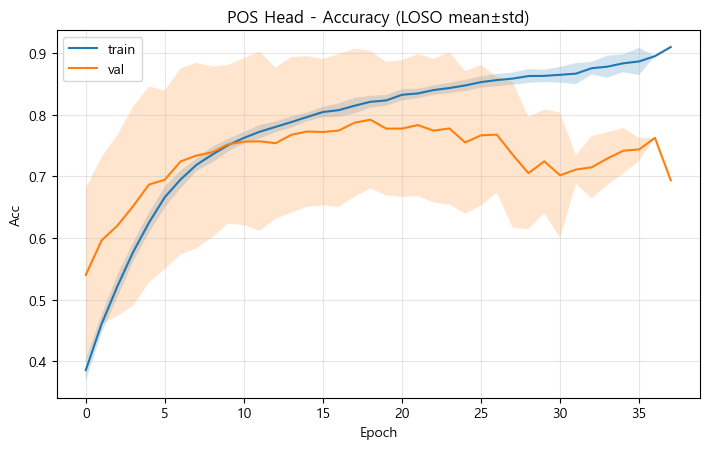

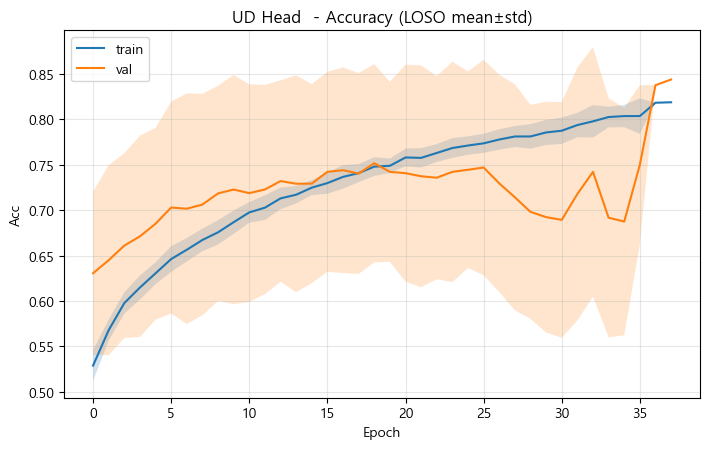

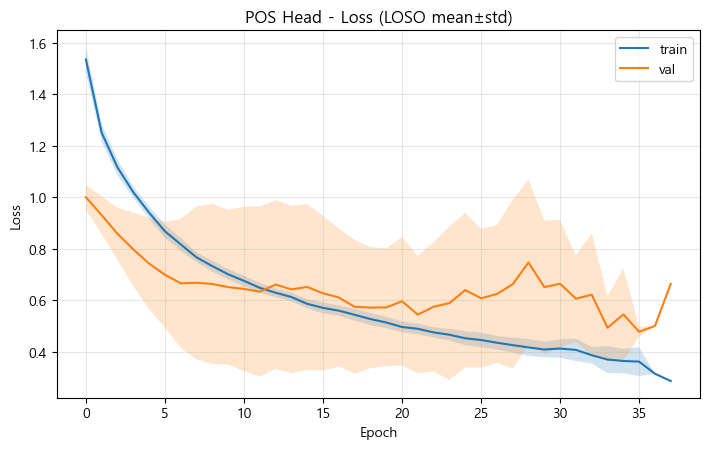

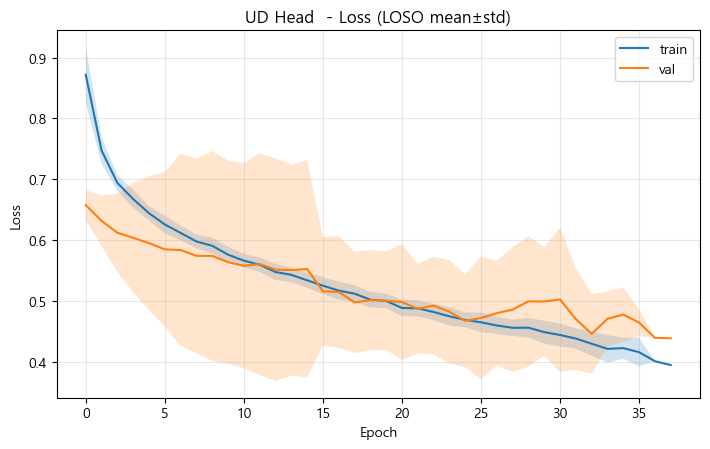

In [47]:
# === 멀티태스크 LOSO 학습 ===
histories = []
fold_metrics = []

# 윈도 단위(검증) 예측/정답/메타 전부 모아두기
all_val_pos_prob = []   # list of (Ni, 3)
all_val_ud_prob  = []   # list of (Ni, 2)
all_val_pos_true = []   # list of (Ni,)
all_val_ud_true  = []   # list of (Ni,)
all_val_src      = []   # list of (Ni,) strings (원본 클립 경로)
all_val_person   = []   # list of (Ni,) strings

for i, f in enumerate(folds_mt, start=1):
    print(f"\n===== [Multitask LOSO Fold {i}] =====")
    Xtr, Xva = f["Xtr"], f["Xva"]
    y_pos_tr, y_pos_va = f["y_pos_tr"], f["y_pos_va"]
    y_ud_tr,  y_ud_va  = f["y_ud_tr"],  f["y_ud_va"]

    model = build_multitask_from_gru(
        input_shape=(Xtr.shape[1], Xtr.shape[2]),
        loss_w_pos=1.0, loss_w_ud=0.5,  # 초기: pos 우선
    )

    # 클래스 가중치(불균형시만)
    cw_pos = make_class_weight(y_pos_tr)
    cw_ud  = make_class_weight(y_ud_tr)
    sw_pos = make_sample_weight(y_pos_tr, cw_pos)
    sw_ud  = make_sample_weight(y_ud_tr, cw_ud)

    cb = [
        tf.keras.callbacks.EarlyStopping(patience=ES_PATIENCE, restore_best_weights=True, monitor='val_loss'),
        tf.keras.callbacks.ReduceLROnPlateau(patience=RLR_PATIENCE, factor=0.5, min_lr=1e-5, monitor='val_loss'),
    ]

    h = model.fit(
        Xtr, {"out_pos": y_pos_tr, "out_ud": y_ud_tr},
        validation_data=(Xva, {"out_pos": y_pos_va, "out_ud": y_ud_va}),
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        sample_weight={"out_pos": sw_pos, "out_ud": sw_ud},
        callbacks=cb, verbose=1
    )
    histories.append(h.history)

    # 검증셋 예측(확률)
    pos_prob_va, ud_prob_va = model.predict(Xva, verbose=0)
    all_val_pos_prob.append(pos_prob_va)
    all_val_ud_prob.append(ud_prob_va)
    all_val_pos_true.append(y_pos_va)
    all_val_ud_true.append(y_ud_va)

    all_val_src.append(f["src_va"])        
    all_val_person.append(f["persons_va"])

    # fold별 수치
    total_loss, pos_loss, pos_acc, ud_loss, ud_acc = model.evaluate(
        Xva, {"out_pos": y_pos_va, "out_ud": y_ud_va}, verbose=0)
    fold_metrics.append({
        "pos_acc": float(pos_acc),
        "ud_acc":  float(ud_acc),
        "pos_loss": float(pos_loss),
        "ud_loss":  float(ud_loss),
        "total_loss": float(total_loss)
    })
    print(f"[Fold {i}] pos_acc={pos_acc:.3f}, ud_acc={ud_acc:.3f}, total_loss={total_loss:.3f}")


# === 성능 요약 및 시각화 ===
import numpy as np
from collections import defaultdict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# --- 윈도 단위 acc ---
win_pos_acc_fold = [accuracy_score(y, np.argmax(p,1)) 
                    for y,p in zip(all_val_pos_true, all_val_pos_prob)]
win_ud_acc_fold  = [accuracy_score(y, np.argmax(p,1)) 
                    for y,p in zip(all_val_ud_true, all_val_ud_prob)]

print("\n==== LOSO Summary (fold-wise, WINDOW) ====")
print(f"POS  Mean Window Acc: {np.mean(win_pos_acc_fold):.3f} ± {np.std(win_pos_acc_fold):.3f}")
print(f"UD   Mean Window Acc: {np.mean(win_ud_acc_fold):.3f} ± {np.std(win_ud_acc_fold):.3f}")


# --- 클립 단위 acc & 전체 리포트 ---
def clip_agg_acc_foldwise(all_prob, all_true, all_src):
    fold_clip_acc = []
    overall_true, overall_pred = [], []
    for prob, y_true, src in zip(all_prob, all_true, all_src):
        buckets, true_by_src = defaultdict(list), {}
        for p,t,s in zip(prob, y_true, src):
            buckets[s].append(p)
            true_by_src[s] = int(t)
        clips_true, clips_pred = [], []
        for s, plist in buckets.items():
            mean_p = np.mean(plist, axis=0)
            clips_true.append(true_by_src[s])
            clips_pred.append(int(np.argmax(mean_p)))
        fold_clip_acc.append(accuracy_score(clips_true, clips_pred))
        overall_true.extend(clips_true)
        overall_pred.extend(clips_pred)
    return fold_clip_acc, np.array(overall_true), np.array(overall_pred)

# POS
clip_pos_acc_fold, clip_pos_true_all, clip_pos_pred_all = clip_agg_acc_foldwise(
    all_val_pos_prob, all_val_pos_true, all_val_src)
print("\n==== LOSO Summary (fold-wise, CLIP, POS) ====")
print(f"Mean Clip Acc: {np.mean(clip_pos_acc_fold):.3f} ± {np.std(clip_pos_acc_fold):.3f}")

# UD
clip_ud_acc_fold, clip_ud_true_all, clip_ud_pred_all = clip_agg_acc_foldwise(
    all_val_ud_prob, all_val_ud_true, all_val_src)
print("\n==== LOSO Summary (fold-wise, CLIP, UD) ====")
print(f"Mean Clip Acc: {np.mean(clip_ud_acc_fold):.3f} ± {np.std(clip_ud_acc_fold):.3f}")

# --- OVERALL 리포트 & 혼동행렬 ---
def print_report_and_cm(y_true, y_pred, labels, title):
    print(f"\n==== OVERALL (클립, {title}) ====")
    print(f"Overall 클립 Acc: {accuracy_score(y_true, y_pred):.3f}")
    print(classification_report(y_true, y_pred, target_names=labels, digits=3))
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
    cm_norm = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True).clip(min=1)
    print("Confusion Matrix (counts):\n", cm)
    return cm, cm_norm

cm_pos, cm_pos_norm = print_report_and_cm(clip_pos_true_all, clip_pos_pred_all, ["왼쪽","중앙","오른쪽"], "POS")
cm_ud,  cm_ud_norm  = print_report_and_cm(clip_ud_true_all,  clip_ud_pred_all,  ["위","아래"], "UD")

def plot_cm(cm_norm, labels, title):
    plt.figure(figsize=(4.8,4.2))
    plt.imshow(cm_norm, interpolation='nearest', cmap='Blues', vmin=0.0, vmax=1.0)
    plt.title(title); plt.xlabel("예측 레이블"); plt.ylabel("실제 레이블")
    plt.xticks(range(len(labels)), labels); plt.yticks(range(len(labels)), labels)
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            plt.text(j, i, f"{cm_norm[i,j]:.2f}", ha='center', va='center')
    plt.colorbar(); plt.tight_layout(); plt.show()

plot_cm(cm_pos, ["왼쪽","중앙","오른쪽"], "POS Confusion Matrix (clip)")
plot_cm(cm_ud,  ["위","아래"], "UD Confusion Matrix (clip)")


# --- 에포크별 평균 그래프 ---
def pad_to_max_len(series_list):
    L = max(len(s) for s in series_list)
    out = np.full((len(series_list), L), np.nan, dtype=np.float32)
    for i,s in enumerate(series_list):
        out[i,:len(s)] = s
    return out

def mean_std_curve(histories, key):
    series = [h[key] for h in histories if key in h]
    if not series: return None,None
    arr = pad_to_max_len(series)
    return np.nanmean(arr,axis=0), np.nanstd(arr,axis=0)

def plot_train_val(histories, key_tr, key_va, title, ylabel):
    mtr, strd = mean_std_curve(histories,key_tr)
    mva, sva  = mean_std_curve(histories,key_va)
    if mtr is None or mva is None: return
    x = np.arange(len(mtr))
    plt.figure(figsize=(7.2,4.6))
    plt.plot(x, mtr, label="train"); plt.fill_between(x, mtr-strd, mtr+strd, alpha=0.2)
    plt.plot(x, mva, label="val");   plt.fill_between(x, mva-sva, mva+sva, alpha=0.2)
    plt.title(title); plt.xlabel("Epoch"); plt.ylabel(ylabel)
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# Accuracy
plot_train_val(histories, "out_pos_accuracy", "val_out_pos_accuracy", "POS Head - Accuracy (LOSO mean±std)", "Acc")
plot_train_val(histories, "out_ud_accuracy",  "val_out_ud_accuracy",  "UD Head  - Accuracy (LOSO mean±std)", "Acc")

# Loss
plot_train_val(histories, "out_pos_loss", "val_out_pos_loss", "POS Head - Loss (LOSO mean±std)", "Loss")
plot_train_val(histories, "out_ud_loss",  "val_out_ud_loss",  "UD Head  - Loss (LOSO mean±std)", "Loss")



==================== POS 헤드 (왼/중/오) ====================

==== LOSO Summary (fold-wise) ====
Mean Window Acc: 0.776 ± 0.150
Mean Clip   Acc: 0.788 ± 0.166

==== OVERALL (클립) ====
Overall 클립 Acc: 0.811
              precision    recall  f1-score   support

          왼쪽      0.865     0.784     0.823       204
          중앙      0.771     0.848     0.808        99
         오른쪽      0.784     0.819     0.801       199

    accuracy                          0.811       502
   macro avg      0.806     0.817     0.810       502
weighted avg      0.814     0.811     0.811       502



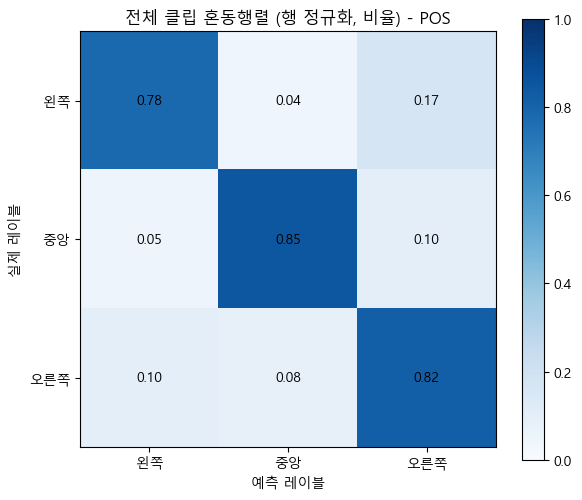

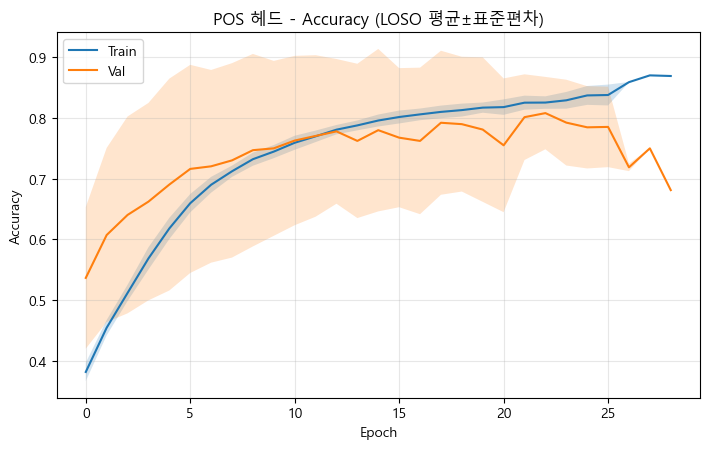

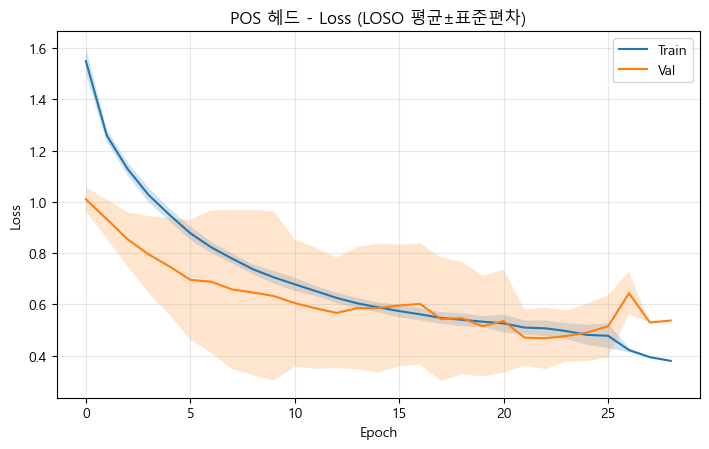


==================== UD 헤드 (위/아래) ====================

==== LOSO Summary (fold-wise) ====
Mean Window Acc: 0.713 ± 0.130
Mean Clip   Acc: 0.709 ± 0.141

==== OVERALL (클립) ====
Overall 클립 Acc: 0.729
              precision    recall  f1-score   support

           위      0.719     0.748     0.733       250
          아래      0.740     0.710     0.725       252

    accuracy                          0.729       502
   macro avg      0.729     0.729     0.729       502
weighted avg      0.729     0.729     0.729       502



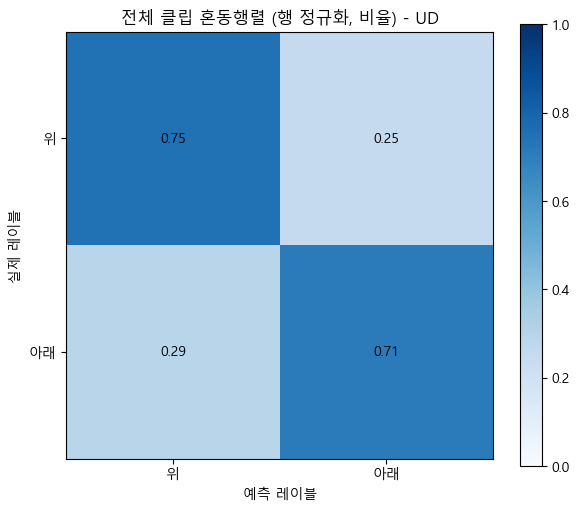

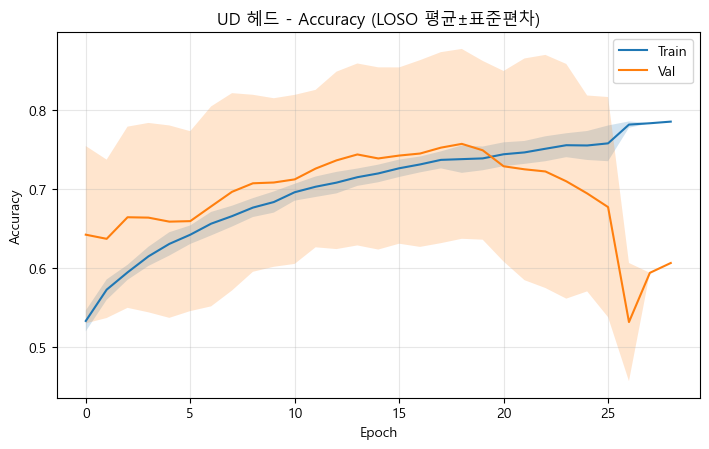

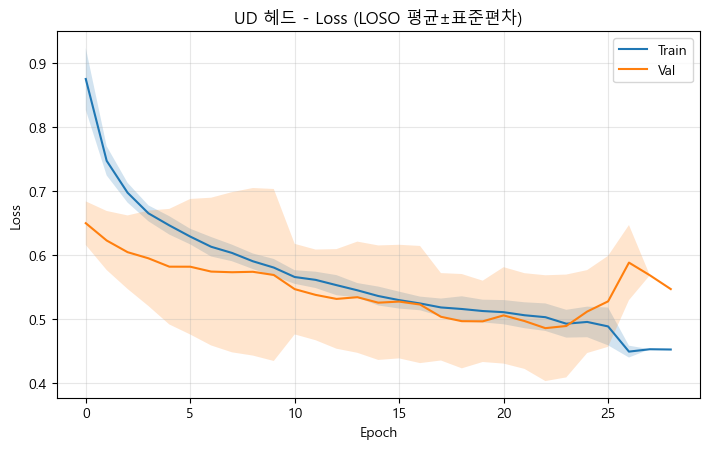

In [44]:
# === LOSO 평균 그래프: 헤드별로 train+val 한 플롯에 표시 ===
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
from collections import defaultdict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 한글 폰트 + minus 기호
def setup_korean_font():
    candidates = ["Malgun Gothic", "AppleGothic", "NanumGothic", "Noto Sans CJK KR", "Noto Sans KR"]
    installed = {f.name for f in font_manager.fontManager.ttflist}
    for name in candidates:
        if name in installed:
            plt.rcParams["font.family"] = name
            break
    plt.rcParams["axes.unicode_minus"] = False

setup_korean_font()

# 안전 체크
if any(s is None for s in all_val_src):
    raise KeyError("folds_mt에 'src_va'가 비어 있습니다. folds_mt 생성 시 'src_va'를 넣어주세요.")

def loso_window_acc(all_true, all_prob):
    """fold-wise window acc list"""
    return [accuracy_score(y, np.argmax(p, axis=1))
            for y, p in zip(all_true, all_prob)]

def clip_agg_foldwise(all_prob, all_true, all_src):
    """
    fold별로 src(원본 클립) 단위로 확률 평균→argmax.
    반환: fold별 clip-acc 리스트, 전체 clip-level true, 전체 clip-level pred
    """
    fold_clip_acc = []
    overall_true, overall_pred = [], []

    for prob, y_true, src in zip(all_prob, all_true, all_src):
        buckets = defaultdict(list)  # src -> [prob]
        true_by_src = {}
        for p, t, s in zip(prob, y_true, src):
            buckets[s].append(p)
            true_by_src[s] = int(t)  # 같은 src 내 라벨 동일 가정

        clips_true, clips_pred = [], []
        for s, plist in buckets.items():
            mean_p = np.mean(plist, axis=0)
            clips_true.append(true_by_src[s])
            clips_pred.append(int(np.argmax(mean_p)))

        fold_clip_acc.append(accuracy_score(clips_true, clips_pred))
        overall_true.extend(clips_true)
        overall_pred.extend(clips_pred)

    return np.array(fold_clip_acc), np.array(overall_true), np.array(overall_pred)

def print_summary_and_plot_cm(head_name, all_true, all_prob, all_src, target_names, cm_title):
    # 1) WINDOW acc (fold-wise)
    win_acc = loso_window_acc(all_true, all_prob)
    print("\n==== LOSO Summary (fold-wise) ====")
    print(f"Mean Window Acc: {np.mean(win_acc):.3f} ± {np.std(win_acc):.3f}")

    # 2) CLIP acc (fold-wise) + OVERALL report
    clip_acc_fold, clip_true_all, clip_pred_all = clip_agg_foldwise(all_prob, all_true, all_src)
    print(f"Mean Clip   Acc: {np.mean(clip_acc_fold):.3f} ± {np.std(clip_acc_fold):.3f}")

    print("\n==== OVERALL (클립) ====")
    overall_acc = accuracy_score(clip_true_all, clip_pred_all)
    print(f"Overall 클립 Acc: {overall_acc:.3f}")
    print(classification_report(clip_true_all, clip_pred_all, target_names=target_names, digits=3))

    # 3) Confusion Matrix (row-normalized)
    cm = confusion_matrix(clip_true_all, clip_pred_all, labels=list(range(len(target_names))))
    cm_norm = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True).clip(min=1)

    plt.figure(figsize=(6.2,5.2))
    plt.imshow(cm_norm, interpolation='nearest', cmap='Blues', vmin=0.0, vmax=1.0)
    plt.title(cm_title)
    plt.xlabel("예측 레이블"); plt.ylabel("실제 레이블")
    plt.xticks(range(len(target_names)), target_names)
    plt.yticks(range(len(target_names)), target_names)

    # 셀 안에 비율 표기
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            plt.text(j, i, f"{cm_norm[i,j]:.2f}", ha='center', va='center', color='black')

    plt.colorbar(); plt.tight_layout(); plt.show()

def pad_to_max_len(series_list):
    L = max(len(s) for s in series_list)
    out = np.full((len(series_list), L), np.nan, dtype=np.float32)
    for i, s in enumerate(series_list):
        out[i, :len(s)] = s
    return out  # (folds, epochs)

def mean_std_curve(histories, key):
    series = [h[key] for h in histories if key in h]
    if not series:
        return None, None
    arr = pad_to_max_len(series)  # (F, E)
    return np.nanmean(arr, axis=0), np.nanstd(arr, axis=0)

def plot_train_val_together(histories, key_train, key_val, title, ylabel="Value"):
    m_tr, s_tr = mean_std_curve(histories, key_train)
    m_va, s_va = mean_std_curve(histories, key_val)
    if m_tr is None or m_va is None:
        print(f"[skip] missing keys: {key_train} / {key_val}")
        return
    x = np.arange(len(m_tr))

    plt.figure(figsize=(7.2, 4.6))
    # Train
    plt.plot(x, m_tr, label="Train")
    plt.fill_between(x, m_tr - s_tr, m_tr + s_tr, alpha=0.20)
    # Val
    plt.plot(x, m_va, label="Val")
    plt.fill_between(x, m_va - s_va, m_va + s_va, alpha=0.20)

    plt.title(title)
    plt.xlabel("Epoch"); plt.ylabel(ylabel)
    plt.grid(alpha=0.3); plt.legend()
    plt.tight_layout(); plt.show()

# === POS 헤드 ===
print("\n==================== POS 헤드 (왼/중/오) ====================")
print_summary_and_plot_cm(
    head_name="POS",
    all_true=all_val_pos_true,
    all_prob=all_val_pos_prob,
    all_src=all_val_src,
    target_names=["왼쪽","중앙","오른쪽"],
    cm_title="전체 클립 혼동행렬 (행 정규화, 비율) - POS"
)
plot_train_val_together(
    histories, "out_pos_accuracy", "val_out_pos_accuracy",
    "POS 헤드 - Accuracy (LOSO 평균±표준편차)", "Accuracy"
)
plot_train_val_together(
    histories, "out_pos_loss", "val_out_pos_loss",
    "POS 헤드 - Loss (LOSO 평균±표준편차)", "Loss"
)

# === UD 헤드 ===
print("\n==================== UD 헤드 (위/아래) ====================")
print_summary_and_plot_cm(
    head_name="UD",
    all_true=all_val_ud_true,
    all_prob=all_val_ud_prob,
    all_src=all_val_src,
    target_names=["위","아래"],
    cm_title="전체 클립 혼동행렬 (행 정규화, 비율) - UD"
)
plot_train_val_together(
    histories, "out_ud_accuracy", "val_out_ud_accuracy",
    "UD 헤드 - Accuracy (LOSO 평균±표준편차)", "Accuracy"
)
plot_train_val_together(
    histories, "out_ud_loss", "val_out_ud_loss",
    "UD 헤드 - Loss (LOSO 평균±표준편차)", "Loss"
)